In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns 
import cv2
from PIL import Image
from model import unet
from tqdm import tqdm
import os

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import optim
from torchvision import utils

device = 'cuda' if torch.cuda.is_available() else 'cpu'


c:\coda\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\coda\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
c:\coda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\coda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 3, 572, 572])


In [2]:
file_root = "E:\Satellite image segmentation\dataset\\tiff"
df = pd.read_csv("E:\Satellite image segmentation\dataset\metadata.csv")
df_train = df.loc[df['split']=='train']
df_test = df.loc[df['split']== 'test']
for i in range(0,len(df_train)):
    df_train['png_image_path']=df_train['png_image_path'][i].replace("/","\\")
    df_train['png_label_path']=df_train['png_label_path'][i].replace("/","\\")
for i in range(df_test.index[0],df_test.index[-1]):
    df_test['png_image_path']=df_test['png_image_path'][i].replace("/","\\")
    df_test['png_label_path']=df_test['png_label_path'][i].replace("/","\\")

df_train

C:\Users\shuga\AppData\Local\Temp\ipykernel_27660\1517117737.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['png_image_path']=df_train['png_image_path'][i].replace("/","\\")
C:\Users\shuga\AppData\Local\Temp\ipykernel_27660\1517117737.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['png_label_path']=df_train['png_label_path'][i].replace("/","\\")
C:\Users\shuga\AppData\Local\Temp\ipykernel_27660\1517117737.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,image_id,split,image_souce_url,label_source_url,tiff_image_path,tif_label_path,png_image_path,png_label_path
0,22678915_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,tiff/train/22678915_15.tiff,tiff/train_labels/22678915_15.tif,png\train\22678915_15.png,png\train_labels\22678915_15.png
1,22678930_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,tiff/train/22678930_15.tiff,tiff/train_labels/22678930_15.tif,png\train\22678915_15.png,png\train_labels\22678915_15.png
2,22678945_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,tiff/train/22678945_15.tiff,tiff/train_labels/22678945_15.tif,png\train\22678915_15.png,png\train_labels\22678915_15.png
3,22678960_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,tiff/train/22678960_15.tiff,tiff/train_labels/22678960_15.tif,png\train\22678915_15.png,png\train_labels\22678915_15.png
4,22678975_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,tiff/train/22678975_15.tiff,tiff/train_labels/22678975_15.tif,png\train\22678915_15.png,png\train_labels\22678915_15.png
...,...,...,...,...,...,...,...,...
132,24478855_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,tiff/train/24478855_15.tiff,tiff/train_labels/24478855_15.tif,png\train\22678915_15.png,png\train_labels\22678915_15.png
133,24478870_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,tiff/train/24478870_15.tiff,tiff/train_labels/24478870_15.tif,png\train\22678915_15.png,png\train_labels\22678915_15.png
134,24478885_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,tiff/train/24478885_15.tiff,tiff/train_labels/24478885_15.tif,png\train\22678915_15.png,png\train_labels\22678915_15.png
135,24478900_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,http://www.cs.toronto.edu/~vmnih/data/mass_bui...,tiff/train/24478900_15.tiff,tiff/train_labels/24478900_15.tif,png\train\22678915_15.png,png\train_labels\22678915_15.png


In [3]:
transform = transforms.Compose([
    transforms.Resize((572,572)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], # imagenet
    #                    [0.229, 0.224, 0.225])
])

class Dataset(Dataset):
    def __init__(self,df,root=file_root,transforms=None,var=""):
        super(Dataset).__init__()
        self.df = df
        self.root = file_root 
        self.var = var 
        self.transform = transforms
        self.imgs = os.listdir(os.path.join(root,self.var))
        self.masks = os.listdir(os.path.join(root,self.var+"_labels"))
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root,self.var,self.imgs[idx])
        #mask_path = self.root+'\\'+self.df['png_label_path'][idx]
        mask_path = os.path.join(self.root,self.var+"_labels",self.masks[idx])
        img = Image.open(img_path).convert('RGB')
        mask =  Image.open(mask_path)
        if self.transform is not None:
            img  = self.transform(img)
            mask = self.transform(mask)
        
        
        return img,mask
    
# def collate_fn(batch):
#     images,masks = zip(*batch)
    
#     return images, masks


        
train_dataset = Dataset(df=df_train,root=file_root,transforms=transform,var="train")
test_dataset = Dataset(df=df_test,root=file_root,transforms=transform,var="test")
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [9]:
#Hyperparameter 
model = unet(3).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=3e-4)
Epocs = 1

In [11]:
for e in range(Epocs):
    #model.train()
    for (img,mask) in tqdm(train_loader,total=len(train_loader)):
        img,mask = img.to(device),mask.to()
      #  print(img)
        pre = model(img)
       # print(pre.shape)
        loss = loss_fn(pre,mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epocs {e} loss: {loss.item()}")

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [02:06<00:00, 14.07s/it]

Epocs 0 loss: 0.5838828086853027


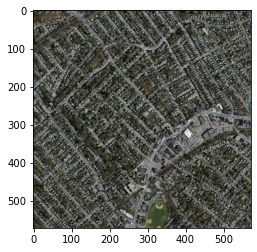

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


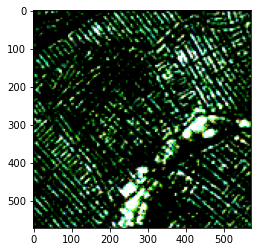

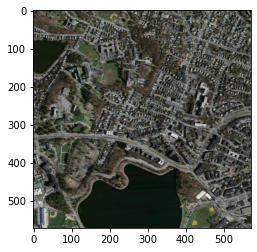

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


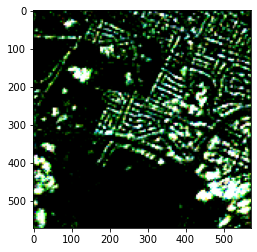

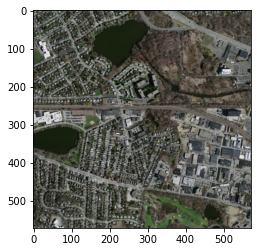

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


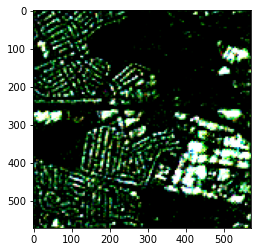

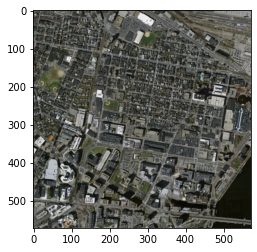

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


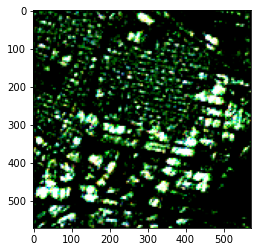

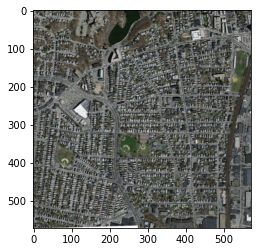

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


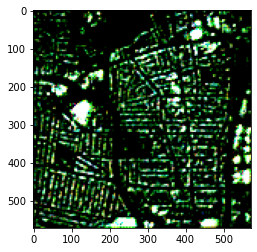

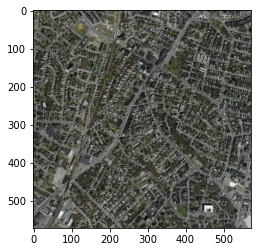

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


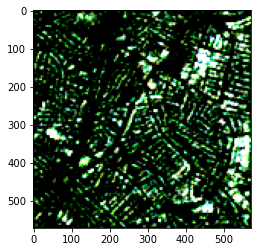

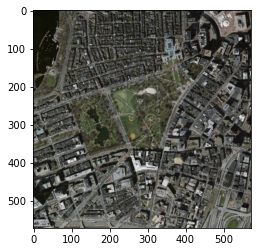

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


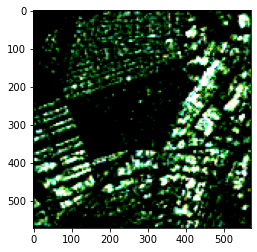

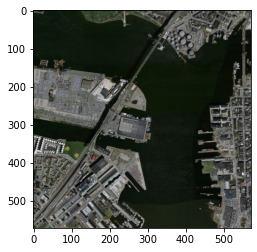

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


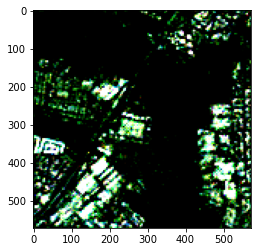

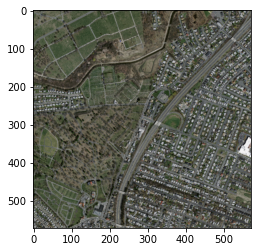

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


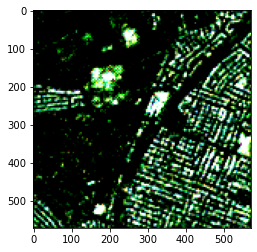

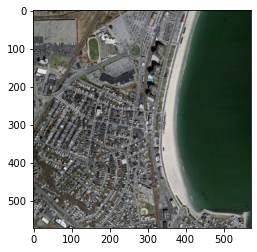

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


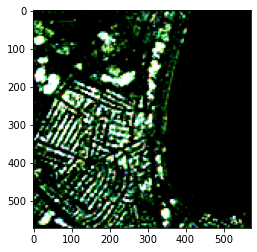

In [14]:
for img,mas in test_loader:
   # print(img)
    pre = model(img)
    img = np.array(img).squeeze(0)
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()
    pre = pre.detach().numpy().squeeze(0)
    plt.imshow(np.transpose(pre,(1,2,0)))
    plt.show()

    